# Assignment 03 - Auto-encoders and The U-net Model

This assignment is composed of two tasks:

1. Design an auto-encoder to denoise a simple image dataset composed of circles;

2. Implement the U-net model for signal denoising;

Each task corresponds to 50% of the final grade of the assignment. Teams with less than 4 people can choose to do just one of the tasks without any penalty. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. 
    - Name the notebook as enel645_assignment03_team_(team number).ipynb
2. The weights of your Auto-encoder and U-net models. 
    - Name the weights files as team_(team number)_autoencoder.h5 (task 01) and team_(team number)_unet.h5 (task 02)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page (two files if your team has less than 4 people)

You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on:

1. Code execution - 20% 
2. Clarity of the code and your model explanation (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%

The data for this assignment can be downloaded here:
- [GDrive](https://drive.google.com/file/d/17XmiQ1lNOP28blGmTFv8Zf5cf08unGgV/view?usp=sharing)
- [OneDrive](https://uofc-my.sharepoint.com/:u:/g/personal/roberto_medeirosdeso_ucalgary_ca/EVe0Mh19GUBGp7qXOIaXRtIBYeJgBtBvc5ULFoT1svhudw?e=rVNREx) - Link expires March 8th, 2021. 

## 1. Denoising Auto-encoder

Develop an auto-encoders that receives as input a 96 x 96 noisy image with a circle of a radius R and outputs the corresponding denoised image. Make the dimensionality of your latent space as low as posisble without compromising the results of the denoised images.

- Justify the choice of your latent space dimension;
- The results will be assessed visually;  

In [1]:
# Import additional libraries if you need
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### 1.1 Load data 

In [2]:
# Adapt the paths to your environment
X_train = np.load("Data/Assignment03/AUTOENCODER/train.npy")[:,:,:,np.newaxis]
X_val = np.load("Data/Assignment03/AUTOENCODER/val.npy")[:,:,:,np.newaxis]
X_test = np.load("Data/Assignment03/AUTOENCODER/test.npy")
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2000, 96, 96, 1)
(500, 96, 96, 1)
(20, 96, 96)


### 1.2. Explore your data 

In [3]:
# Use this space to explore you datasets
# Create additional cells as you see fit
print(X_train.max(), X_train.min(), X_train.mean(), X_train.std())
print(X_val.max(), X_val.min(), X_val.mean(), X_val.std())
print(X_test.max(), X_test.min(), X_test.mean(), X_test.std())

1.4873135181389396 -0.5244176555743066 0.06483575576181211 0.26572640224784966
1.444695593969531 -0.48315215630414876 0.06560921122081251 0.2668220989782381
1.4065173771244017 -0.5060637694290917 0.059938670003646284 0.2575862096490328


### 1.3. Data scaling and Data augmentation

In [3]:
# Experiment with different data scaling methods
norm_type = 2 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = (X_train + 0.6)/2.1
    X_val = (X_val + 0.6)/2.1
    X_test = (X_test + 0.6)/2.1
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass

In [4]:
# Create your data augmentation object to improve training
# set your batch size
batch_size = 32
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
               "cval": 0}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,X_train,batch_size = batch_size)
val_flow = val_gen.flow(X_val,X_val,batch_size = batch_size)

#### Define plot function for training loss vs validation loss

In [ ]:
def plot_history( H ):
    n = len(H.history["loss"])
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    
    fig.add_subplot(1, 1, 1)
    plt.plot(np.arange(0, n), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, n), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    
    plt.show()

### 1.4. Define your  model, cost function, optimizer, learning rate

In [5]:
# Define your model here. 
def my_autoencoder(ishape = (96,96,1),ndim = 10, lr = 1e-4):
    input_img = tf.keras.layers.Input(shape=ishape)
    encode = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    encode = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(encode)
    encode = tf.keras.layers.MaxPool2D()(encode)
    encode = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(encode)
    encode = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(encode)
    encode = tf.keras.layers.MaxPool2D()(encode)
    encode = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(encode)
    encode = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(encode)
    encode = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(encode)
    encode = tf.keras.layers.MaxPool2D()(encode)
    encode = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(encode)
    encode = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(encode)
    encode = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(encode)
    encode = tf.keras.layers.MaxPool2D()(encode)
    encode = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(encode)
    encode = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(encode)
    encode = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(encode)
    encode = tf.keras.layers.MaxPool2D()(encode)
    encoded = tf.keras.layers.Flatten()(encode)
    encoded = tf.keras.layers.Dense(ndim)(encoded)
    encoder = tf.keras.models.Model(inputs=input_img, outputs=encoded)
    decoder_input = tf.keras.layers.Input(shape=(ndim))
    decode = tf.keras.layers.Dense(3*3*256)(decoder_input)
    decode = tf.keras.layers.Reshape((3,3,256))(decode)
    decode = tf.keras.layers.UpSampling2D((2,2))(decode)
    decode = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(decode)
    decode = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(decode)
    decode = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(decode)
    decode = tf.keras.layers.UpSampling2D((2,2))(decode)
    decode = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(decode)
    decode = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(decode)
    decode = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(decode)
    decode = tf.keras.layers.UpSampling2D((2,2))(decode)
    decode = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(decode)
    decode = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(decode)
    decode = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(decode)
    decode = tf.keras.layers.UpSampling2D((2,2))(decode)
    decode = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(decode)
    decode = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(decode)
    decode = tf.keras.layers.UpSampling2D((2,2))(decode)
    decode = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(decode)
    decode = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(decode)
    decoded = tf.keras.layers.Conv2D(1, (3,3), activation = 'relu', padding = 'same')(decode)
    decoder = tf.keras.models.Model(inputs=decoder_input, outputs=decoded)
    autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoder(encoder(input_img)))
    autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = "mse")
    
    return encoder,decoder,autoencoder

### 1.5. Define your callbacks (save your model, patience, etc.)

In [6]:
model_name_autoencoder = "team_48_autoencoder.h5"

# define your callbacks
# remember that you need to save the weights of your best model!
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_autoencoder, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%5 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

### 1.6. Train your model

In [7]:
encoder,decoder,autoencoder = my_autoencoder(ndim = 4)
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())
# ndim = 7 -> val_loss = 0.0755 (detail loss)
# ndim = 6 -> val_loss = 0.0117
# ndim = 5 -> val_loss = 0.0121
# ndim = 4 -> val_loss = 0.0121 - 0.0034 (min-max) - 0.2237 (average)
# ndim = 3 -> val_loss = 0.0124

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0     

In [9]:
# train your model - decide for how many epochs
history = autoencoder.fit(train_flow, epochs = 30, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/30
63/63 [==============================] - 104s 1s/step - loss: 0.9965 - val_loss: 0.5452
Epoch 2/30
63/63 [==============================] - 74s 1s/step - loss: 0.4870 - val_loss: 0.4248
Epoch 3/30
63/63 [==============================] - 76s 1s/step - loss: 0.4095 - val_loss: 0.3924
Epoch 4/30
63/63 [==============================] - 76s 1s/step - loss: 0.3784 - val_loss: 0.3704
Epoch 5/30
63/63 [==============================] - 76s 1s/step - loss: 0.3634 - val_loss: 0.3542
Epoch 6/30
63/63 [==============================] - 76s 1s/step - loss: 0.3375 - val_loss: 0.3203
Epoch 7/30
63/63 [==============================] - 76s 1s/step - loss: 0.3029 - val_loss: 0.3199
Epoch 8/30
63/63 [==============================] - 76s 1s/step - loss: 0.3008 - val_loss: 0.2797
Epoch 9/30
63/63 [==============================] - 76s 1s/step - loss: 0.2680 - val_loss: 0.2770
Epoch 10/30
63/63 [==============================] - 76s 1s/step - loss: 0.2639 - val_loss: 0.2634
Epoch 11/30
63/63 

In [ ]:
plot_hsitory(history)

### 1.7. Test your model

In [8]:
autoencoder.load_weights(model_name_autoencoder)
Xpred = autoencoder.predict(X_test)[:,:,:,0]

# Remember to "unscale your data".
if norm_type == 0:
    X_train = X_train*2.1 - 0.6
    X_val = X_val*2.1 - 0.6
    X_test = X_test*2.1 - 0.6
    Xpred = Xpred*2.1 - 0.6
elif norm_type == 1:
    X_train = X_train*train_std + train_mean
    X_val = X_val*train_std + train_mean
    X_test = X_test*train_std + train_mean
    Xpred = Xpred*train_std + train_mean
else:
    pass

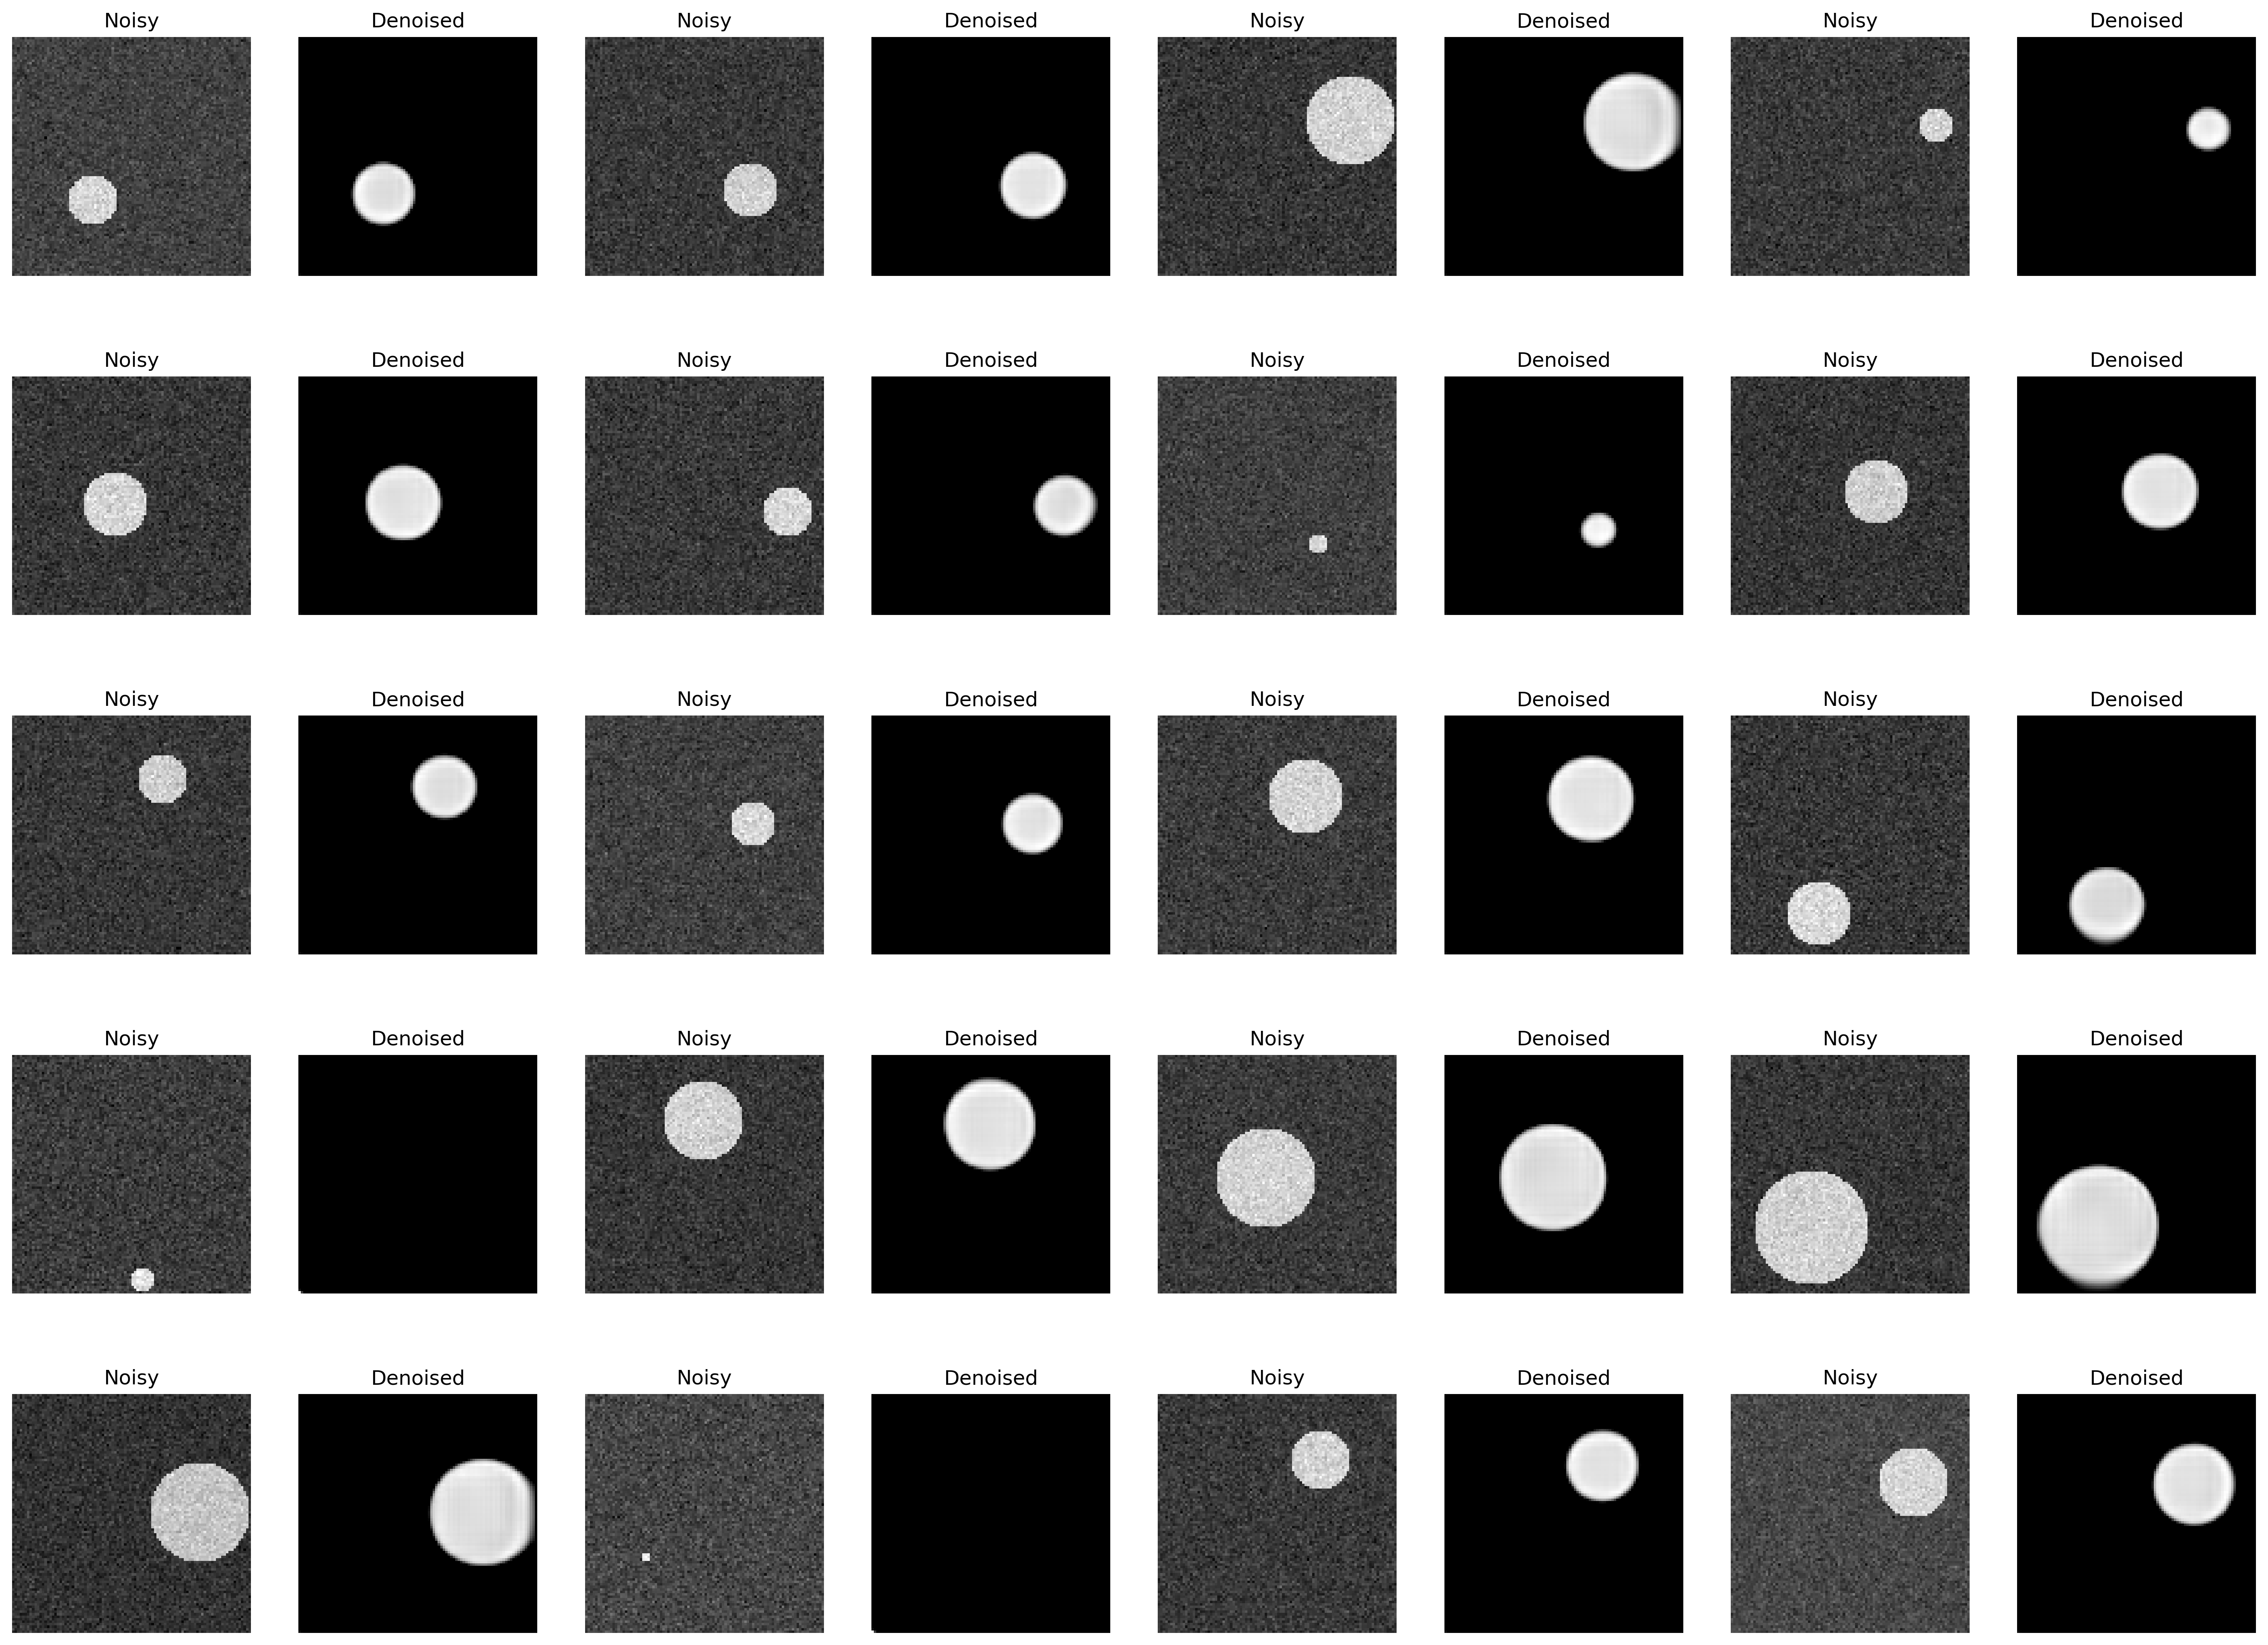

In [9]:
#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(20):
    plt.subplot(5,8,ii*2+1)
    plt.imshow(X_test[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Noisy")
    plt.subplot(5,8,ii*2 + 2)
    plt.imshow(Xpred[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Denoised")
plt.show()

In [10]:
print(X_test.max(), X_test.min(), X_test.mean(), X_test.std())
print(Xpred.max(), Xpred.min(), Xpred.mean(), Xpred.std())

1.4065173771244017 -0.5060637694290917 0.059938670003646284 0.2575862096490328
1.1698135 0.0 0.07510359 0.25506523


## 2. Denoising U-net

Develop an U-net model that receives as input 20 1-dimensional noisy measurements of the same signal and outputs the denoised signal.

The mean squared error (MSE) of your U-net model should be lower than the MSE of just averaging the noisy measurements. 

- The results will be assessed using mean squared error. 

### 2.1 Load data  and split into train, validation, test

In [22]:
data = np.load("Data/Assignment03/UNET/noisy_transients.npy")
target = np.load("Data/Assignment03/UNET/reference.npy")
indexes = np.arange(data.shape[0], dtype = int)
np.random.shuffle(indexes)
data = data[indexes]
target = target[indexes]
X_train2 = data[:int(data.shape[0]*0.8)]
Y_train2 = target[:int(data.shape[0]*0.8)]

X_val2 = data[int(data.shape[0]*0.8):int(data.shape[0]*0.9)]
Y_val2 = target[int(data.shape[0]*0.8):int(data.shape[0]*0.9)]

X_test2 = data[int(data.shape[0]*0.9):]
Y_test2 = target[int(data.shape[0]*0.9):]

print(X_train2.shape)
print(X_val2.shape)
print(X_test2.shape)

(216, 256, 20)
(27, 256, 20)
(27, 256, 20)


### 2.2. Explore your data

In [3]:
# Use this space to explore you datasets
# Create additional cells as you see fit
print(X_train2.max(), X_train2.min(), X_train2.mean(), X_train2.std())
print(X_val2.max(), X_val2.min(), X_val2.mean(), X_val2.std())
print(X_test2.max(), X_test2.min(), X_test2.mean(), X_test2.std())
print(Y_train2.max(), Y_train2.min(), Y_train2.mean(), Y_train2.std())
print(Y_val2.max(), Y_val2.min(), Y_val2.mean(), Y_val2.std())
print(Y_test2.max(), Y_test2.min(), Y_test2.mean(), Y_test2.std())

3.7456143553633217 -2.9169581831740183 0.20422559108452715 0.7218733748578624
3.4844627790345424 -2.690131998960042 0.19359662257232627 0.7287828687807628
3.3674503064407553 -2.4815304787429904 0.20119372787973605 0.7596895598154294
1.9995952979705165 -1.1411321715982128 0.20401760253655257 0.5808202324548839
1.9995952979705165 -1.1411321715982128 0.1934817499042078 0.5929286871377851
1.9995952979705165 -1.1411321715982128 0.19957953624052394 0.6278356854135828


### 2.3. Data scaling and Data augmentation

In [23]:
# Experiment with different data scaling methods
norm_type = 1 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train2 = (X_train2 + 3)/7
    X_val2 = (X_val2 + 3)/7
    X_test2 = (X_test2 + 3)/7
    Y_train2 = (Y_train2 + 3)/7
    Y_val2 = (Y_val2 + 3)/7
    Y_test2 = (Y_test2 + 3)/7
elif norm_type == 1:
    train_mean, train_std = X_train2.mean(),X_train2.std() 
    X_train2 = (X_train2 - train_mean)/train_std
    X_val2 = (X_val2 - train_mean)/train_std
    X_test2 = (X_test2 - train_mean)/train_std
    Y_train2 = (Y_train2 - train_mean)/train_std
    Y_val2 = (Y_val2 - train_mean)/train_std
    Y_test2 = (Y_test2 - train_mean)/train_std
else:
    pass
X_train3 = np.repeat(Y_train2[:,:,np.newaxis], 20, axis=2)
X_val3 = np.repeat(Y_val2[:,:,np.newaxis], 20, axis=2)
print(X_train3.shape)
print(X_val3.shape)

(216, 256, 20)
(27, 256, 20)


In [85]:
# Create your data augmentation object to improve training
# set your batch size
batch_size = 2
def augmentations(input_data, target_data):
    #flip
    if np.random.rand()<0.5:    
        input_data = input_data[::-1]
        target_data = target_data[::-1]

    return input_data, target_data
def Datagen(input_dataset, target_dataset, batch_size=batch_size, is_train=True):
    x=[]
    y=[]
  
    count=0
    idx_1 = np.arange(len(input_dataset))
    np.random.shuffle(idx_1)

    while True:
        for i in range(len(input_dataset)):
            input_data = input_dataset[idx_1[i]]
            target_data = target_dataset[idx_1[i]]

            if is_train:
                input_data, target_data = augmentations(input_data, target_data)
                
            x.append(input_data)
            y.append(target_data)
            count+=1
            if count==batch_size:
                x=np.array(x, dtype=np.float32)
                y=np.array(y, dtype=np.float32)
                inputs = x
                targets = y       
                x = []
                y = []
                count=0
                yield inputs, targets

train_flow = Datagen(X_train2, X_train3)
val_flow = Datagen(X_val2, X_val3, is_train=False)

### 2.4. Define your  model, cost function, optimizer, learning rate

In [92]:
# Define your model here. 
from tensorflow.keras.layers import *
def conv(x, out, kernel, stride, dilation, padding="same"):
    x = Conv1D(out, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding=padding)(x)
    #x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def my_unet(ishape = (256,20),lr = 1e-3):
    layers = 72
    kernel = 3
    depth = 2
    learning_decay = 1e-6
    input_sig = Input(shape=ishape)

    ### Encoding
    x = conv(input_sig, layers, kernel, 1, 1)
    for i in range(depth - 1):
      x = conv(x, layers, kernel, 1, 1)
    out_1 = x
    x = conv(x, layers*2, kernel, 2, 1)
    for i in range(depth):
      x = conv(x, layers*2, kernel, 1, 1)
    out_2 = x

    x = conv(x, layers*4, kernel, 2, 1)
    for i in range(depth):
      x = conv(x, layers*4, kernel, 1, 1)
    out_3 = x

    x = conv(x, layers*8, kernel, 2, 1)
    for i in range(depth):
      x = conv(x, layers*8, kernel, 1, 1)
    out_4 = x
    x = conv(x, layers*16, kernel, 2, 1)
    for i in range(depth):
      x = conv(x, layers*16, kernel, 1, 1)
    ### Decoding
    x = UpSampling1D()(x)
    x = concatenate([out_4, x], axis=-1)
    for i in range(depth):
      x = conv(x, layers*8, kernel, 1, 1)
    x = UpSampling1D()(x)
    x = concatenate([out_3, x], axis=-1)
    for i in range(depth):
      x = conv(x, layers*4, kernel, 1, 1)
    x = UpSampling1D()(x)
    x = concatenate([out_2, x], axis=-1)
    for i in range(depth):
      x = conv(x, layers*2, kernel, 1, 1)
    x = UpSampling1D()(x)
    x = concatenate([out_1, x], axis=-1)
    for i in range(depth):
      x = conv(x, layers, kernel, 1, 1)
    x = Conv1D(20, kernel_size=1, strides=1)(x)
    out = Activation("linear")(x)
    out = Add()([out, input_sig])

    model = tf.keras.models.Model(inputs=input_sig, outputs=out)
    opt = tf.keras.optimizers.Adam(lr= lr, decay = learning_decay)
    model.compile(optimizer= opt,loss='mse')
    return model

### 2.5. Define your callbacks (save your model, patience, etc.)

In [87]:
model_name_unet = "team_48_unet.h5"

# define your callbacks
# remember that you need to save the weights of your best model!
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_unet, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch % 5 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

### 2.6. Train your model

In [93]:
model = my_unet()
print(model.summary())

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 256, 20)]    0                                            
__________________________________________________________________________________________________
conv1d_539 (Conv1D)             (None, 256, 72)      4392        input_23[0][0]                   
__________________________________________________________________________________________________
activation_501 (Activation)     (None, 256, 72)      0           conv1d_539[0][0]                 
__________________________________________________________________________________________________
conv1d_540 (Conv1D)             (None, 256, 72)      15624       activation_501[0][0]             
___________________________________________________________________________________________

In [94]:
# train your model - decide for how many epochs
history = model.fit(train_flow, validation_data = (val_flow), \
                   steps_per_epoch=len(X_train2)//batch_size, validation_steps=len(X_val2)//batch_size,\
                    epochs=60,verbose=1, callbacks = [early_stop, monitor, lr_schedule])

Epoch 1/60
108/108 [==============================] - 30s 246ms/step - loss: 0.3042 - mse: 0.3042 - val_loss: 0.1472 - val_mse: 0.1472
Epoch 2/60
108/108 [==============================] - 26s 242ms/step - loss: 0.1213 - mse: 0.1213 - val_loss: 0.0702 - val_mse: 0.0702
Epoch 3/60
108/108 [==============================] - 26s 241ms/step - loss: 0.0603 - mse: 0.0603 - val_loss: 0.0408 - val_mse: 0.0408
Epoch 4/60
108/108 [==============================] - 26s 242ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 5/60
108/108 [==============================] - 26s 241ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0273 - val_mse: 0.0273
Epoch 6/60
108/108 [==============================] - 26s 243ms/step - loss: 0.0243 - mse: 0.0243 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 7/60
108/108 [==============================] - 26s 241ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 8/60
108/108 [==============================] - 2

In [ ]:
plot_history(history)

### 2.7. Test your model

In [95]:
model.load_weights(model_name_unet)
Ypred = model.predict(X_test2)[:,:,0]

Ymean = X_test2.mean(axis = -1)


# Remember to "unscale your data".
if norm_type == 0:
    X_test2 = X_test2*7 - 3
    Y_test2 = Y_test2*7 - 3
    Ymean = Ymean*7 - 3
    Ypred = Ypred*7 - 3
elif norm_type == 1:
    X_test2 = X_test2*train_std + train_std
    Y_test2 = Y_test2*train_std + train_std
    Ymean = Ymean*train_std + train_std
    Ypred = Ypred*train_std + train_std
else:
    pass

print("Unet MSE:")
print(((Ypred - Y_test2)**2).mean())
print("Mean MSE:")
print(((Ymean - Y_test2)**2).mean())


Unet MSE:
0.004317632067250158
Mean MSE:
0.008958412539004387


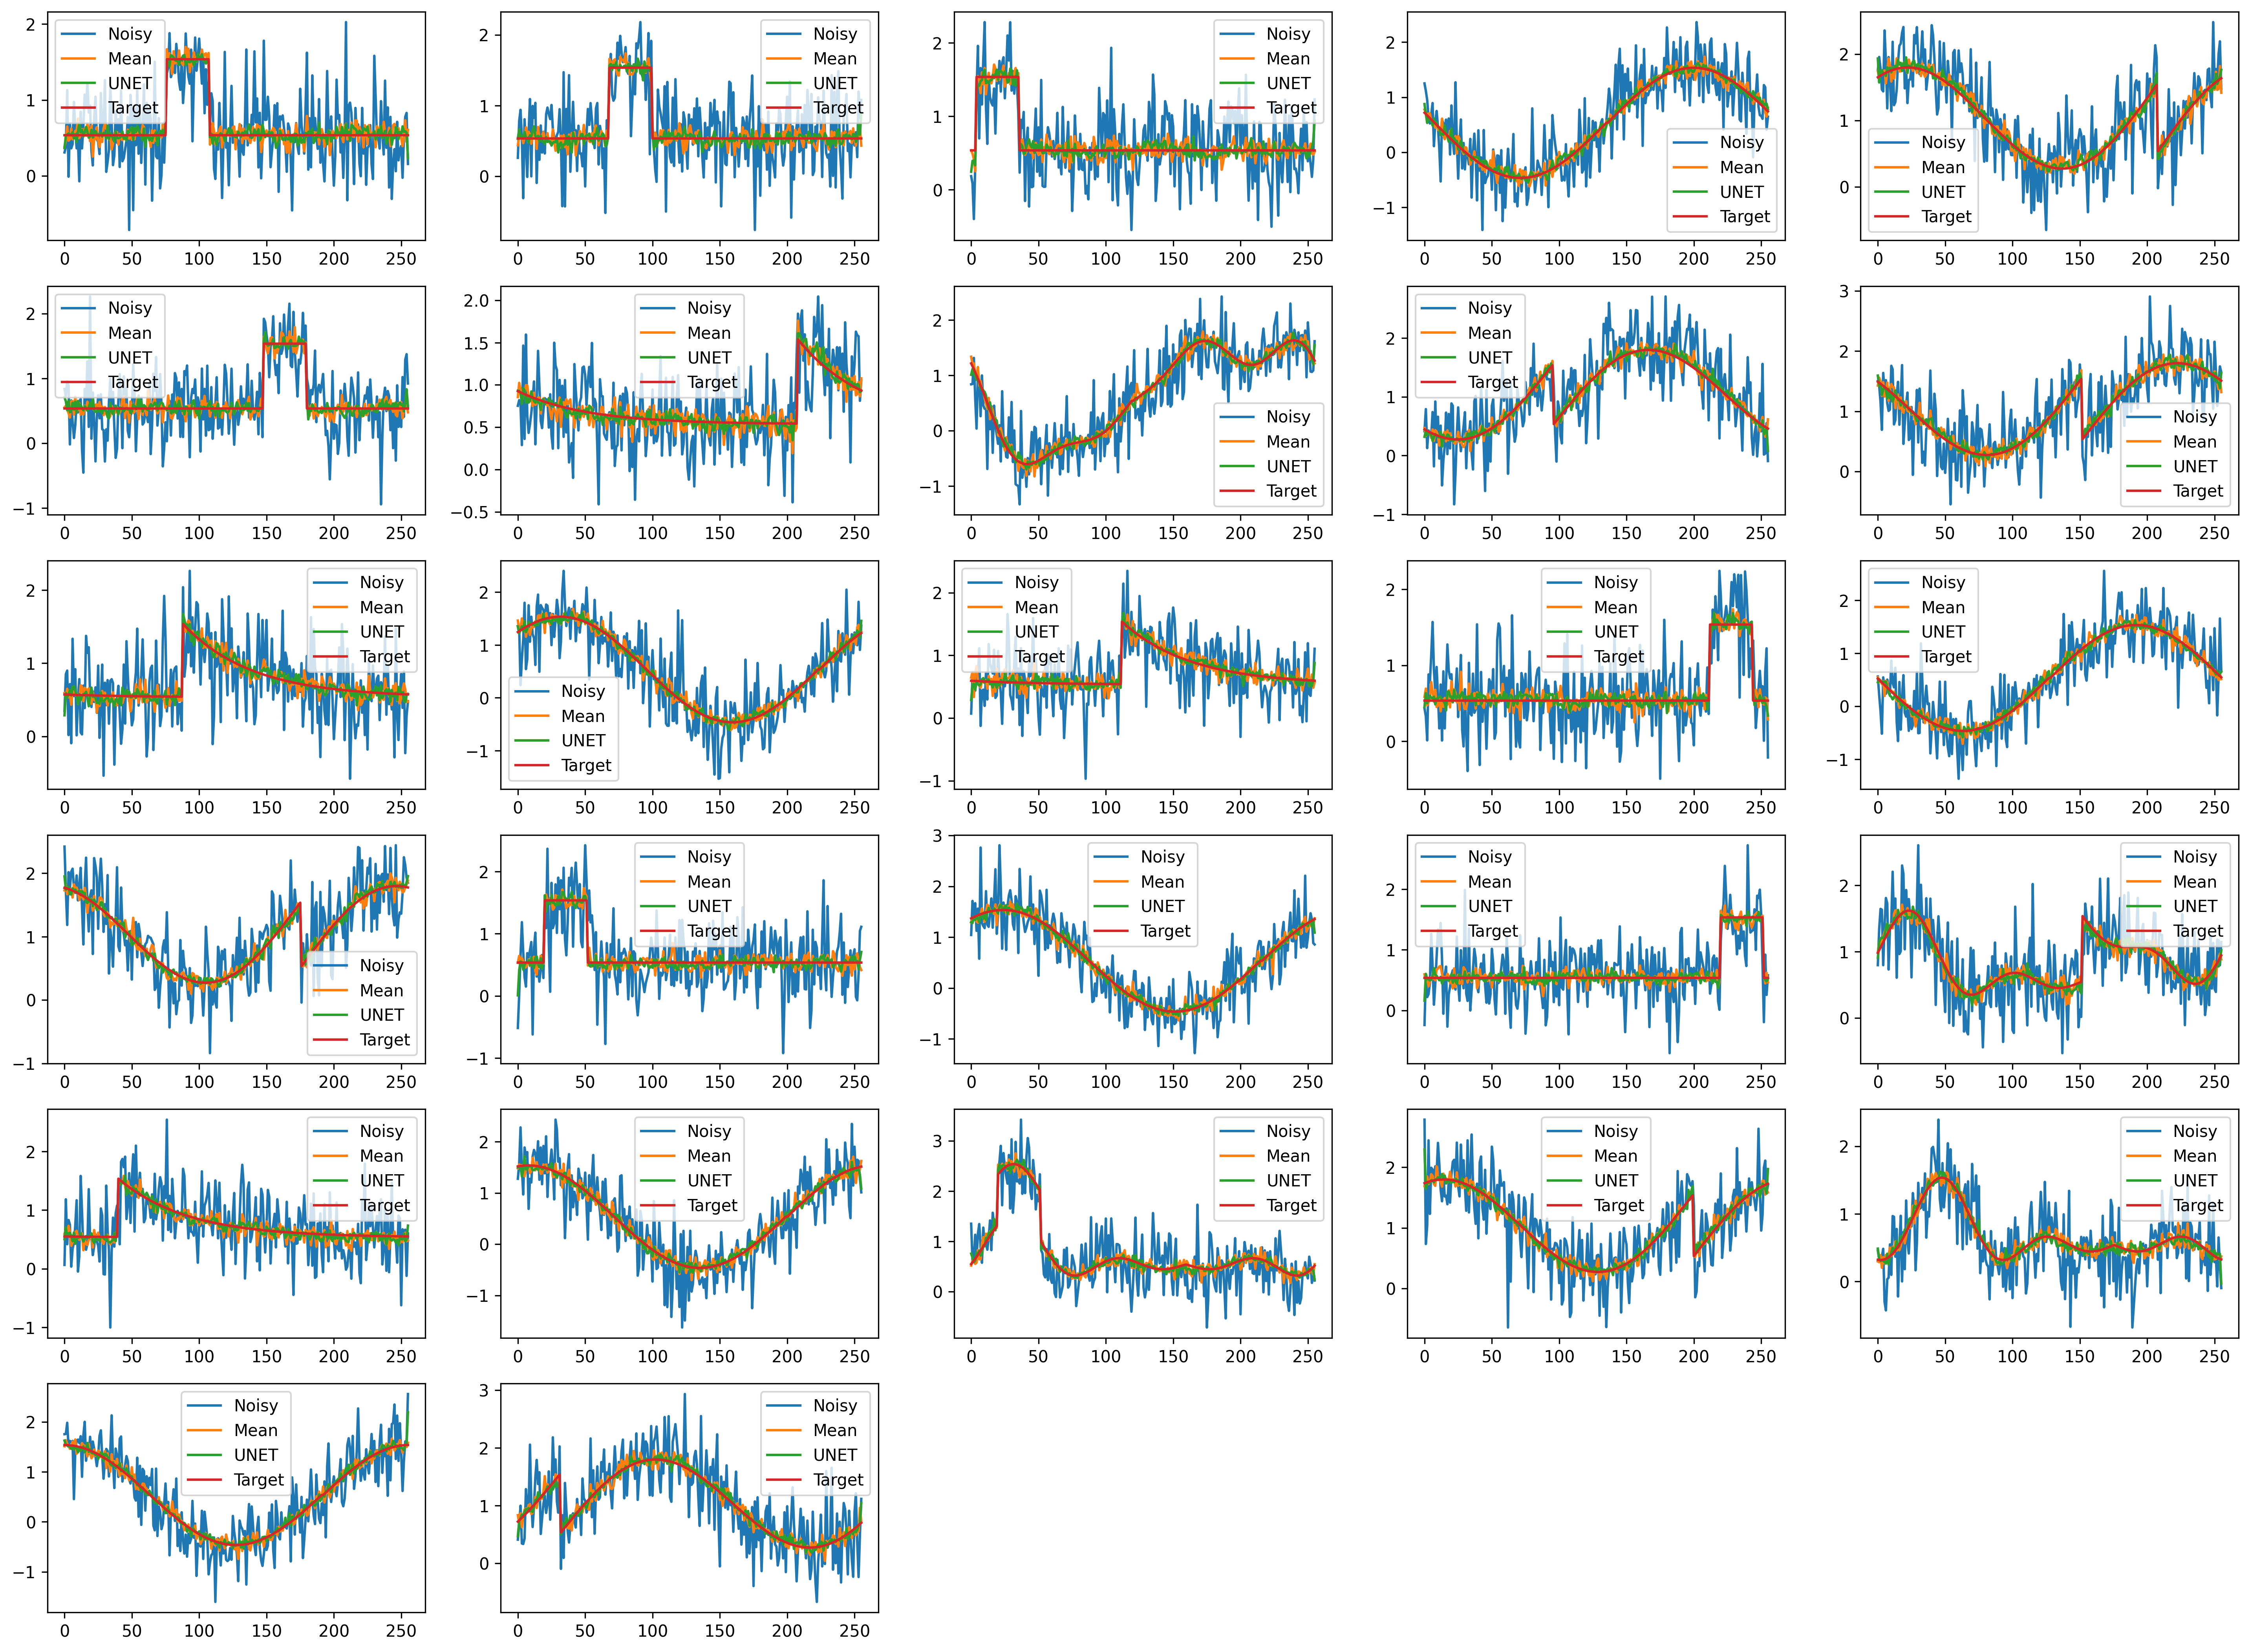

In [96]:
#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(27):
    plt.subplot(6,5,ii+1)
    plt.plot(X_test2[ii,:,0], label = "Noisy")
    plt.plot(Ymean[ii], label = "Mean")
    plt.plot(Ypred[ii], label = "UNET")
    plt.plot(Y_test2[ii], label = "Target")
    plt.legend()
plt.show()

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Do Trong Anh, Aaron Joseph, Alan Joseph, Bright Anorchie** helped design the model and write the code for fully connected model (**score 3**)
- **Do Trong Anh, Aaron Joseph, Alan Joseph, Bright Anorchie** helped design helped to implement the data augmentation module (**score 3**)